# Concealed Pistol Detection

### Imports

In [ ]:
#imports for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

#imports for vision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

#imports for preparing dataset
import os
import zipfile
#from google.colab import files
#from google.colab import drive

#imports for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Preparing Dataset

In [ ]:
#applying a transformation to the entire dataset, standardizing it
#reshapes the image to guarantee a 256 size
#grayscales the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

#relative directory path
#ImageFolder sets classes based on folder names
dataset_dir = "Data/ConcealedPistolDataset/"
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

#initialize train, validation, and test sets
train_size = int(0.8 * len(dataset))              #80% for training
val_size = int(0.1 * len(dataset))                #10% for validation
test_size = len(dataset) - train_size - val_size  #10% (remainder) for test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#print sizes of datasets
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

#set the dataloaders to use the datasets
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#variable to define number of classes
num_classes = 2


Train size: 286
Valid size: 35
Test size: 37


### Setting device to GPU 

In [ ]:
#setting device to gpu if availible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#confirm device
print("Device:", device)


Device: cuda


### Visualizing the transformed dataset

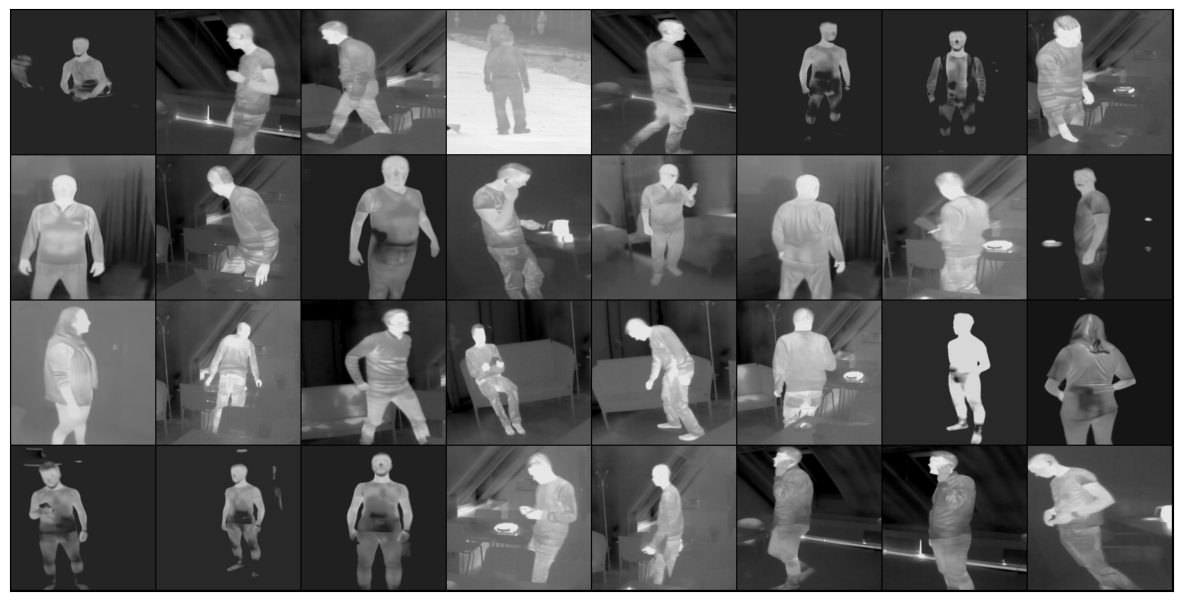

In [5]:
#plotting a grid of a single batch
def show_batch(dataLoader):
    for images, labels in dataLoader:
        fig, ax = plt.subplots(figsize = (15, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch(train_dl)

### Defining the model

In [6]:
#definition for a CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        #model takes input of 256 x 256 x 1
        #make sure in_channels aligns with out_channels from the previous layer

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(2,2)

        #8 x 8 x 128 comes from sizing, the pool in each layer cut dimensionality in half, 128 is out channels
        self.fc1 = nn.Linear(in_features = (8 * 8 * 128), out_features = 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features = 64, out_features = num_classes)


    def forward(self, input):
        #forward pass first block
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        outputPool1 = self.pool1(output)

        #forward pass second block
        output = self.conv2(outputPool1)
        output = self.bn2(output)
        output = self.relu(output)
        outputPool2 = self.pool2(output)

        #forward pass third block
        output = self.conv3(outputPool2)
        output = self.bn3(output)
        output = self.relu(output)
        outputPool3 = self.pool3(output)

        #forward pass fourth block
        output = self.conv4(outputPool3)
        output = self.bn4(output)
        output = self.relu(output)
        outputPool4 = self.pool4(output)

        #forward pass fifth block
        output = self.conv5(outputPool4)
        output = self.bn5(output)
        output = self.relu(output)
        outputPool5 = self.pool5(output)


        #forward pass flattening
        output = outputPool5.view(-1, 128 * 8 * 8)

        #forward pass fully connected layers
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc2(output)

        return output

model = Network().to(device)

#channels, height, width
summary(model,(1, 256, 256))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

### Defining Loss and Optimizer


In [7]:
#cross entropy loss
criterion = nn.CrossEntropyLoss()
#adam optimizer
learningRate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learningRate)